In [183]:
%matplotlib inline

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

import matplotlib.pyplot as plt

In [3]:
uband = fits.open('frame-u-000756-4-0200.fits')
gband = fits.open('frame-g-000756-4-0200.fits')
rband = fits.open('frame-r-000756-4-0200.fits')
iband = fits.open('frame-i-000756-4-0200.fits')
zband = fits.open('frame-z-000756-4-0200.fits')

coords = SkyCoord(145.8002, 0.4141723, unit=(u.deg, u.deg))

In [4]:
gband[0].header

SIMPLE  =                    T /                                                
BITPIX  =                  -32 / 32 bit floating point                          
NAXIS   =                    2                                                  
NAXIS1  =                 2048                                                  
NAXIS2  =                 1489                                                  
EXTEND  =                    T /Extensions may be present                       
BZERO   =              0.00000 /Set by MRD_SCALE                                
BSCALE  =              1.00000 /Set by MRD_SCALE                                
TAI     =        4428795142.48 / 1st row - Number of seconds since Nov 17 1858  
RA      =            146.37926 / 1st row - Right ascension of telescope boresigh
DEC     =           -0.002768  / 1st row - Declination of telescope boresight (d
SPA     =              90.005  / 1st row - Camera col position angle wrt north (
IPA     =              89.95

In [5]:
def object_RADEC_to_XY(obj_RA, obj_DEC, fits_header):
    '''
    Function copied from: 
    https://acrider.wordpress.com/2015/02/04/revised-python-code-for-converting-ra-dec-to-x-y/
    
    and is closely adapted from IDL's AD2XY.PRO:
    http://www.sdss3.org/svn/repo/idlutils/tags/v5_5_5/goddard/pro/astrom/ad2xy.pro
    
    Also check out:
    https://www.galaxyzooforum.org/index.php?topic=280337.0
    https://forum.cosmoquest.org/showthread.php?137475-How-to-cut-out-a-region-from-an-SDSS-FITS-image-file
    
    Parameters
    ----------
    obj_RA : float
        object right ascension in degrees
    obj_DEC : float
        object declination in degrees
    fits_header : HDUList
        FITS file header info
        
    Returns
    -------
    obj_X : float
        object x-coordinate
    obj_Y : float
        object y-coordinate
    '''
    
    # Make sure the RA, DEC coordinate type is TAN
    if (fits_header['CTYPE1'] != 'RA---TAN') or (fits_header['CTYPE2'] != 'DEC--TAN'):
        print ('ERROR: Wrong coordinate type CTYPE1 or CTYPE2 for this object!')
        print ('\t CTYPE1 = ', fits_header['CTYPE1'])
        print ('\t CTYPE2 = ', fits_header['CTYPE2'])
        
    # These values allow translation from RA, DEC to X,Y and vice versa
    CRPIX1 = fits_header['CRPIX1'] - 1 # X of reference pixel
    CRPIX2 = fits_header['CRPIX2'] - 1 # Y of reference pixel
    CRVAL1 = fits_header['CRVAL1'] # RA of reference pixel (deg)
    CRVAL2 = fits_header['CRVAL2'] # DEC of reference pixel (deg)
    CD1_1 = fits_header['CD1_1'] # RA deg per column pixel
    CD1_2 = fits_header['CD1_2'] # RA deg per row pixel
    CD2_1 = fits_header['CD2_1'] # DEC deg per column pixel
    CD2_2 = fits_header['CD2_2'] # DEC deg per row pixel
    
    # Find the X, Y values of the galaxy's RA and DEC
    det = CD1_1 * CD2_2 - CD1_2 * CD2_1

    CD_inv_11 = CD2_2 / det
    CD_inv_12 = -CD1_2 / det
    CD_inv_21 = -CD2_1 / det
    CD_inv_22 = CD1_1 / det

    ra0 = CRVAL1 / 180.0 * np.pi
    dec0 = CRVAL2 / 180.0 * np.pi
    ra = obj_RA / 180.0 * np.pi
    dec = obj_DEC / 180.0 * np.pi

    denominator = np.sin(dec)*np.sin(dec0) + np.cos(dec)*np.cos(dec0)*np.cos(ra-ra0)

    xi = np.cos(dec) * np.sin(ra-ra0) / denominator
    eta = (np.sin(dec)*np.cos(dec0) - np.cos(dec)*np.sin(dec0)*np.cos(ra-ra0)) / denominator
    xi = xi * 180.0 / np.pi
    eta = eta * 180.0 / np.pi

    obj_X = CD_inv_11 * xi + CD_inv_12 * eta + CRPIX1
    obj_Y = CD_inv_21 * xi + CD_inv_22 * eta + CRPIX2

    return obj_X, obj_Y

In [6]:
ux, uy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, uband[0].header)
print (ux, uy)

gx, gy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, gband[0].header)
print (gx, gy)

rx, ry = object_RADEC_to_XY(coords.ra.value, coords.dec.value, rband[0].header)
print (rx, ry)

ix, iy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, iband[0].header)
print (ix, iy)

zx, zy = object_RADEC_to_XY(coords.ra.value, coords.dec.value, zband[0].header)
print (zx, zy)

1924.9745803317744 949.4915849725992
1923.7172083797932 954.5158166929345
1922.8381353388913 943.7396602170237
1922.6110655118428 947.0572008331305
1921.714530004453 951.4158588720214


In [23]:
gband[0].shape # rows (number of y pixels), columns (number of x pixels)

(1489, 2048)

In [32]:
int(round(gx, 0)), int(round(gy, 0))

(1924, 955)

In [26]:
gx, gy

(1923.7172083797932, 954.5158166929345)

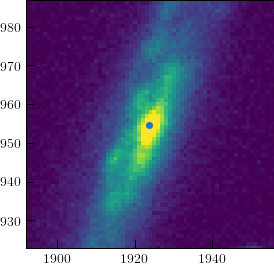

In [33]:
gxmin, gxmax = int(round(gx, 0))-32, int(round(gx, 0))+32
gymin, gymax = int(round(gy, 0))-32, int(round(gy, 0))+32

plt.imshow(gband[0].data, vmin=0.005, vmax=1.0)
plt.scatter(gx, gy)
plt.gca().invert_yaxis()
plt.xlim(gxmin, gxmax)
plt.ylim(gymin, gymax)
plt.show()

In [45]:
uxmin, uxmax = int(round(ux, 0))-32, int(round(ux, 0))+32
uymin, uymax = int(round(uy, 0))-32, int(round(uy, 0))+32

gxmin, gxmax = int(round(gx, 0))-32, int(round(gx, 0))+32
gymin, gymax = int(round(gy, 0))-32, int(round(gy, 0))+32

rxmin, rxmax = int(round(rx, 0))-32, int(round(rx, 0))+32
rymin, rymax = int(round(ry, 0))-32, int(round(ry, 0))+32

ixmin, ixmax = int(round(ix, 0))-32, int(round(ix, 0))+32
iymin, iymax = int(round(iy, 0))-32, int(round(iy, 0))+32

zxmin, zxmax = int(round(zx, 0))-32, int(round(zx, 0))+32
zymin, zymax = int(round(zy, 0))-32, int(round(zy, 0))+32

In [93]:
print (np.min(uband[0].data.flatten()), np.max(uband[0].data.flatten()))
print (np.min(gband[0].data.flatten()), np.max(gband[0].data.flatten()))
print (np.min(rband[0].data.flatten()), np.max(rband[0].data.flatten()))
print (np.min(iband[0].data.flatten()), np.max(iband[0].data.flatten()))
print (np.min(zband[0].data.flatten()), np.max(zband[0].data.flatten()))

-0.2084961 287.5
-0.09289551 177.0
-0.13183594 221.5
-0.24023438 115.125
-1.1269531 1920.0


In [78]:
ulev = np.percentile(uband[0].data.flatten(), [16, 50, 84])
glev = np.percentile(gband[0].data.flatten(), [16, 50, 84])
rlev = np.percentile(rband[0].data.flatten(), [16, 50, 84])
ilev = np.percentile(iband[0].data.flatten(), [16, 50, 84])
zlev = np.percentile(zband[0].data.flatten(), [16, 50, 84])

print (ulev, glev, rlev, ilev, zlev)

[-0.0411377   0.00216293  0.04534912] [-0.01782227 -0.00014567  0.02017212] [-0.02670288  0.00140381  0.02984619] [-0.04351807  0.00093651  0.05029297] [-0.20996094  0.01205444  0.23486328]


/Users/thsyu/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


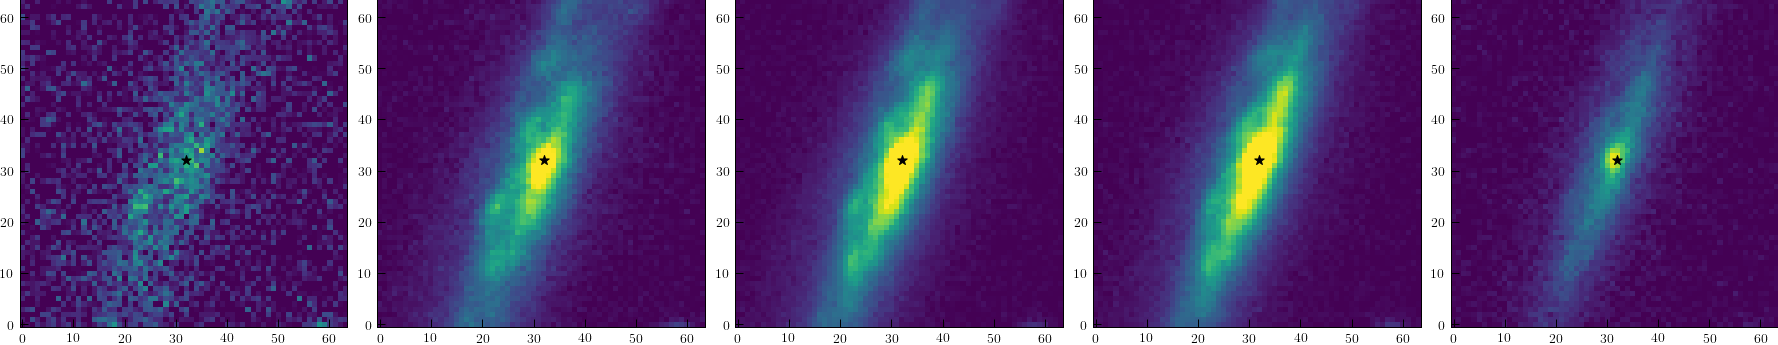

In [99]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 5))

ax1.imshow(uband[0].data[uymin:uymax, uxmin:uxmax], vmin=0.002, vmax=0.4)
ax1.scatter(32, 32, marker='*', color='black', s=100)
ax1.invert_yaxis()

ax2.imshow(gband[0].data[gymin:gymax, gxmin:gxmax], vmin=0.0001, vmax=1.0)
ax2.scatter(32, 32, marker='*', color='black', s=100)
ax2.invert_yaxis()

ax3.imshow(rband[0].data[rymin:rymax, rxmin:rxmax], vmin=0.002, vmax=2.0)
ax3.scatter(32, 32, marker='*', color='black', s=100)
ax3.invert_yaxis()

ax4.imshow(iband[0].data[iymin:iymax, ixmin:ixmax], vmin=0.001, vmax=3.0)
ax4.scatter(32, 32, marker='*', color='black', s=100)
ax4.invert_yaxis()

ax5.imshow(zband[0].data[zymin:zymax, zxmin:zxmax], vmin=0.002, vmax=10.)
ax5.scatter(32, 32, marker='*', color='black', s=100)
ax5.invert_yaxis()

fig.show()

In [35]:
stack_img = np.zeros((64, 64, 5))

In [100]:
stack_img[:, :, 0] = uband[0].data[uymin:uymax, uxmin:uxmax]
stack_img[:, :, 1] = gband[0].data[gymin:gymax, gxmin:gxmax]
stack_img[:, :, 2] = rband[0].data[rymin:rymax, rxmin:rxmax]
stack_img[:, :, 3] = iband[0].data[iymin:iymax, ixmin:ixmax]
stack_img[:, :, 4] = zband[0].data[zymin:zymax, zxmin:zxmax]

In [173]:
all_imgs = np.zeros((2, 64*64*5))

In [174]:
all_imgs[0] = stack_img.flatten()
all_imgs[1] = stack_img.flatten()

In [175]:
np.savetxt('test.txt', all_imgs, fmt='%.12f', delimiter=" ", newline="\n")

In [176]:
tst = np.loadtxt('test.txt')

In [177]:
tst.shape

(2, 20480)

In [178]:
X_train = tst.reshape(2, 64, 64, 5)

In [179]:
X_train[0].shape, X_train[1].shape

((64, 64, 5), (64, 64, 5))

In [180]:
X_train.shape

(2, 64, 64, 5)

In [184]:
galspec = pd.read_csv('galspec_RS_uimg_thsyu.csv', delimiter=',')

In [188]:
galspec

,specObjID,oii_3726_flux,oii_3726_flux_err,oii_3729_flux,oii_3729_flux_err,oiii_4363_flux,oiii_4363_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,...,ra,dec,z,z_err,z_warning,spectrotype,subclass,sn_median,reliable,uimg
0,299610073498413056,32.239510,9.289029,51.520840,9.391968,6.583977,4.067094,62.27009,3.727642,25.256910,...,145.8002,0.414172,0.025250,0.000015,0,GALAXY,STARFORMING,24.85177,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
1,300619975029188608,22.840210,5.347836,12.878540,5.433570,-2.936492,2.588634,13.65540,2.449598,0.556210,...,148.5656,-0.936083,0.089717,0.000015,0,GALAXY,STARFORMING,11.26074,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
2,300620799662909440,19.622090,5.103601,37.601410,5.532969,3.359770,2.401530,62.44374,2.522492,2.818213,...,148.7270,-1.120984,0.084335,0.000009,0,GALAXY,STARFORMING,10.58121,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
3,300617501128026112,67.504120,9.459218,36.288130,8.483768,5.116489,4.063403,64.29639,4.022976,16.420420,...,148.7329,-0.761159,0.086272,0.000012,0,GALAXY,STARFORMING,25.74401,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
4,300625472587327488,8.157495,4.151037,13.458470,4.343494,-0.481147,2.648729,19.97931,2.387799,4.736043,...,149.1179,0.183989,0.065808,0.000016,0,GALAXY,STARFORMING,20.97153,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252451,3348596274537457664,123.970600,4.732935,141.308800,4.831325,0.485705,1.924320,111.93090,2.520613,22.000050,...,261.2463,31.260670,0.046037,0.000005,0,GALAXY,STARBURST,16.13815,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252452,3348599023316527104,18.342260,2.972998,9.916848,2.900549,-1.211788,1.922055,19.75921,1.660344,4.328686,...,260.7148,32.361810,0.054428,0.000015,0,GALAXY,STARFORMING,16.00852,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252453,3345078112172926976,31.308570,4.027195,41.325920,4.226990,5.126327,1.736035,20.14025,1.474479,8.614512,...,257.0418,36.503830,0.036337,0.000010,0,GALAXY,STARFORMING,10.83265,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252454,3345078936806647808,32.137710,3.524230,54.438860,3.576251,0.372117,1.467489,28.13335,1.432219,8.180933,...,256.8379,36.596520,0.050386,0.000008,0,GALAXY,STARFORMING,11.72034,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...


In [187]:
galspec[galspec['subclass'] == 'STARFORMING']

,specObjID,oii_3726_flux,oii_3726_flux_err,oii_3729_flux,oii_3729_flux_err,oiii_4363_flux,oiii_4363_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,...,ra,dec,z,z_err,z_warning,spectrotype,subclass,sn_median,reliable,uimg
0,299610073498413056,32.239510,9.289029,51.520840,9.391968,6.583977,4.067094,62.27009,3.727642,25.256910,...,145.8002,0.414172,0.025250,0.000015,0,GALAXY,STARFORMING,24.851770,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
1,300619975029188608,22.840210,5.347836,12.878540,5.433570,-2.936492,2.588634,13.65540,2.449598,0.556210,...,148.5656,-0.936083,0.089717,0.000015,0,GALAXY,STARFORMING,11.260740,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
2,300620799662909440,19.622090,5.103601,37.601410,5.532969,3.359770,2.401530,62.44374,2.522492,2.818213,...,148.7270,-1.120984,0.084335,0.000009,0,GALAXY,STARFORMING,10.581210,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
3,300617501128026112,67.504120,9.459218,36.288130,8.483768,5.116489,4.063403,64.29639,4.022976,16.420420,...,148.7329,-0.761159,0.086272,0.000012,0,GALAXY,STARFORMING,25.744010,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
4,300625472587327488,8.157495,4.151037,13.458470,4.343494,-0.481147,2.648729,19.97931,2.387799,4.736043,...,149.1179,0.183989,0.065808,0.000016,0,GALAXY,STARFORMING,20.971530,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252444,3348561914799089664,14.196160,3.690346,23.336850,3.444276,1.024559,1.397171,10.14655,1.283397,1.692069,...,260.3920,31.679210,0.029703,0.000015,0,GALAXY,STARFORMING,8.039813,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252447,3348574559182809088,17.147260,3.240531,20.825790,3.336832,1.675817,1.789195,36.43328,2.041894,5.950243,...,260.5158,31.519950,0.047164,0.000012,0,GALAXY,STARFORMING,19.941670,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252452,3348599023316527104,18.342260,2.972998,9.916848,2.900549,-1.211788,1.922055,19.75921,1.660344,4.328686,...,260.7148,32.361810,0.054428,0.000015,0,GALAXY,STARFORMING,16.008520,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
252453,3345078112172926976,31.308570,4.027195,41.325920,4.226990,5.126327,1.736035,20.14025,1.474479,8.614512,...,257.0418,36.503830,0.036337,0.000010,0,GALAXY,STARFORMING,10.832650,1,http://dr16.sdss.org/sas/dr16/eboss/photoObj/f...
